### Зависимости

In [1]:
!pip install dotenv
!pip install boto3

### Библиотеки

In [2]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm
from scipy.optimize import minimize

import boto3
from dotenv import dotenv_values, find_dotenv

from io import StringIO
from tqdm import tqdm
from typing import Optional

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

### Данные

Данные, собранные парсером, уже сохранены в GitLab. Вы можете загрузить их напрямую оттуда

In [3]:
# подкобчение
config = dotenv_values(find_dotenv("doc_2025-06-19_01-07-06.env"))
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id = config['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key = config['AWS_SECRET_ACCESS_KEY']
)

In [4]:
bytes_data = s3.get_object(Bucket='finrisk-lake', Key="/base_active/combain_data.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8'))

data = pd.read_csv(csv_data).bfill()
data['begin'] = pd.to_datetime(data['begin'])
data

begin  SU26207RMFS9  SU26225RMFS1  SU26229RMFS3  SU26233RMFS5  \
0    2021-01-04       113.929       109.001       108.041        98.250   
1    2021-01-05       113.952       109.237       108.147        98.640   
2    2021-01-06       113.700       109.300       108.180        98.623   
3    2021-01-08       113.702       109.290       108.197        98.341   
4    2021-01-11       113.368       108.299       107.748        97.390   
...         ...           ...           ...           ...           ...   
997  2024-12-25        84.881        60.205        92.087        56.438   
998  2024-12-26        85.380        60.396        92.153        56.741   
999  2024-12-27        85.404        60.348        92.348        56.731   
1000 2024-12-28        84.927        60.318        92.084        57.136   
1001 2024-12-30        84.922        60.400        91.630        57.414   

      SU26235RMFS0  period_0.25  period_0.5  period_0.75  period_1.0  ...  \
0          100.449         4.03        4.09         4.14        4.20  ...   
1          100.478         3.98        4.04         4.11        4.18  ...   
2          101.000         3.85        3.95         4.04        4.11  ...   
3          100.750         3.78        3.88         3.99        4.08  ...   
4           99.800         4.17        4.19         4.22        4.26  ...   
...            ...          ...         ...          ...         ...  ...   
997         61.890        18.33       18.33        18.30       18.24  ...   
998         62.480        17.97       17.99        17.98       17.96  ...   
999         62.440        17.49       17.59        17.64       17.67  ...   
1000        63.059        18.55       18.58        18.57       18.53  ...   
1001        63.018        18.80       18.75        18.68       18.58  ...   

        LKOH   AFLT   GMKN    NVTK    SBER   AFKS    CHMF    ROSN    VTBR  \
0     5213.0  72.06  243.1  1250.4  272.00  29.03  1343.2  436.00  189.63   
1     5359.0  72.74  246.8  1287.4  275.20  29.60  1334.2  449.35  192.22   
2     5377.0  72.96  250.2  1301.2  272.93  29.28  1326.4  453.70  191.18   
3     5557.0  73.58  265.4  1379.2  283.64  29.44  1369.2  478.20  194.70   
4     5599.0  74.08  262.9  1405.4  289.49  30.24  1351.2  473.25  199.45   
...      ...    ...    ...     ...     ...    ...     ...     ...     ...   
997   6988.0  54.86  108.0   929.4  271.69  14.15  1161.8  581.95   76.53   
998   7003.0  55.04  109.7   949.8  269.56  14.09  1174.4  579.10   75.74   
999   6991.0  55.65  111.0   949.2  271.20  14.28  1186.2  591.00   76.49   
1000  6998.0  58.38  113.8   951.8  272.83  14.74  1232.2  596.00   78.09   
1001  7235.0  59.06  115.5   996.0  279.43  15.59  1337.4  606.05   80.03   

        RASP  
0     157.30  
1     156.50  
2     157.36  
3     158.56  
4     158.00  
...      ...  
997   250.25  
998   248.05  
999   251.20  
1000  252.05  
1001  262.70  

[1002 rows x 34 columns]

In [5]:
data.isna().sum()

begin           0
SU26207RMFS9    0
SU26225RMFS1    0
SU26229RMFS3    0
SU26233RMFS5    0
SU26235RMFS0    0
period_0.25     0
period_0.5      0
period_0.75     0
period_1.0      0
period_2.0      0
period_3.0      0
period_5.0      0
period_7.0      0
period_10.0     0
period_15.0     0
period_20.0     0
period_30.0     0
IMOEX           0
RTSI            0
euro_cb         0
oil_price       0
usd_cb          0
ruonia          0
LKOH            0
AFLT            0
GMKN            0
NVTK            0
SBER            0
AFKS            0
CHMF            0
ROSN            0
VTBR            0
RASP            0
dtype: int64

In [6]:
data.columns

Index(['begin', 'SU26207RMFS9', 'SU26225RMFS1', 'SU26229RMFS3', 'SU26233RMFS5',
       'SU26235RMFS0', 'period_0.25', 'period_0.5', 'period_0.75',
       'period_1.0', 'period_2.0', 'period_3.0', 'period_5.0', 'period_7.0',
       'period_10.0', 'period_15.0', 'period_20.0', 'period_30.0', 'IMOEX',
       'RTSI', 'euro_cb', 'oil_price', 'usd_cb', 'ruonia', 'LKOH', 'AFLT',
       'GMKN', 'NVTK', 'SBER', 'AFKS', 'CHMF', 'ROSN', 'VTBR', 'RASP'],
      dtype='object')

Сперва проверим наши данные на стационарность:

In [7]:
factor_cols = [col for col in data.columns if col != 'begin']
# стационарность (базоый кейс)
for col in factor_cols:
    result = adfuller(data[col])
    print(f"{col}: | ADF Statistic: {round(result[0], 2)} | p-value: {round(result[1], 2)}")

SU26207RMFS9: | ADF Statistic: -1.52 | p-value: 0.52
SU26225RMFS1: | ADF Statistic: -1.05 | p-value: 0.73
SU26229RMFS3: | ADF Statistic: -2.27 | p-value: 0.18
SU26233RMFS5: | ADF Statistic: -1.33 | p-value: 0.61
SU26235RMFS0: | ADF Statistic: -1.41 | p-value: 0.58
period_0.25: | ADF Statistic: -0.75 | p-value: 0.83
period_0.5: | ADF Statistic: -0.59 | p-value: 0.87
period_0.75: | ADF Statistic: -0.19 | p-value: 0.94
period_1.0: | ADF Statistic: -0.15 | p-value: 0.94
period_2.0: | ADF Statistic: -0.07 | p-value: 0.95
period_3.0: | ADF Statistic: -0.21 | p-value: 0.94
period_5.0: | ADF Statistic: -0.35 | p-value: 0.92
period_7.0: | ADF Statistic: -0.53 | p-value: 0.89
period_10.0: | ADF Statistic: -0.6 | p-value: 0.87
period_15.0: | ADF Statistic: -0.82 | p-value: 0.81
period_20.0: | ADF Statistic: -1.2 | p-value: 0.67
period_30.0: | ADF Statistic: -1.26 | p-value: 0.65
IMOEX: | ADF Statistic: -1.19 | p-value: 0.68
RTSI: | ADF Statistic: -1.35 | p-value: 0.61
euro_cb: | ADF Statistic: -1

Возьмём лог доходность, чтобы перейти к стационарному ряду

In [8]:
dates = data[['begin']]
numeric_cols = data.select_dtypes(include=[np.number]).copy()
log_returns = np.log(numeric_cols / numeric_cols.shift(1)).dropna()
data_log = dates.loc[log_returns.index].reset_index(drop=True).join(
    log_returns.reset_index(drop=True)
)

In [9]:
for col in factor_cols:
    result = adfuller(data_log[col])
    print(f"{col}: | ADF Statistic: {round(result[0], 2)} | p-value: {round(result[1], 2)}")

SU26207RMFS9: | ADF Statistic: -7.16 | p-value: 0.0
SU26225RMFS1: | ADF Statistic: -7.85 | p-value: 0.0
SU26229RMFS3: | ADF Statistic: -9.31 | p-value: 0.0
SU26233RMFS5: | ADF Statistic: -7.75 | p-value: 0.0
SU26235RMFS0: | ADF Statistic: -7.25 | p-value: 0.0
period_0.25: | ADF Statistic: -12.84 | p-value: 0.0
period_0.5: | ADF Statistic: -10.64 | p-value: 0.0
period_0.75: | ADF Statistic: -10.42 | p-value: 0.0
period_1.0: | ADF Statistic: -10.18 | p-value: 0.0
period_2.0: | ADF Statistic: -8.49 | p-value: 0.0
period_3.0: | ADF Statistic: -7.99 | p-value: 0.0
period_5.0: | ADF Statistic: -6.9 | p-value: 0.0
period_7.0: | ADF Statistic: -7.09 | p-value: 0.0
period_10.0: | ADF Statistic: -7.38 | p-value: 0.0
period_15.0: | ADF Statistic: -9.24 | p-value: 0.0
period_20.0: | ADF Statistic: -14.3 | p-value: 0.0
period_30.0: | ADF Statistic: -13.27 | p-value: 0.0
IMOEX: | ADF Statistic: -10.98 | p-value: 0.0
RTSI: | ADF Statistic: -6.74 | p-value: 0.0
euro_cb: | ADF Statistic: -8.73 | p-valu

Получив стационарные данные можно переходить к понижению размерностей факторов

### PCA - понижение размерности факторов

Разделяем выборку на обучающую и тестовую, а затем уменьшаем размерности пространство факторов отдельно по каждому выделенному блоку

In [10]:
# сплит данных по дате отсечения
test_date = '2024-12-01'
train_data = data_log[data_log['begin'] <= test_date]
test_data = data_log[data_log['begin'] > test_date]

In [11]:
debt_set = ['SU26207RMFS9', 'SU26225RMFS1', 'SU26229RMFS3', 'SU26233RMFS5', 'SU26235RMFS0']
market_set = ['LKOH', 'AFLT', 'GMKN', 'NVTK', 'SBER', 'AFKS', 'CHMF', 'ROSN', 'VTBR', 'RASP']
currency_set = ['euro_cb', 'usd_cb']
active_set = ['oil_price']
index_set = ['IMOEX','RTSI']
rate_set = ['ruonia', 'period_0.25', 'period_0.5', 'period_0.75', 'period_1.0', 'period_2.0', 'period_3.0', 'period_5.0', 'period_7.0',
            'period_10.0', 'period_15.0', 'period_20.0', 'period_30.0']

In [12]:
def create_factor(factor_df:pd.DataFrame, pipe:Optional[Pipeline], n=1) -> np.array:
    """
    Понижаем размерность факторов

    Args:
      factor_df: таблица для понижения размерности
      pipe (Pipeline): если не None, то делает трансформацию без обучения
      n (int): число компонент

    Returns:
        factor (np.array): получившийся фактор
    """
    if pipe is None:
        pipe = Pipeline([
          # ('scaling', StandardScaler()),
          ('pca', PCA(n_components=n)),
          ])
        factor = pipe.fit_transform(factor_df)
    else:
        factor = pipe.transform(factor_df)

    factor = factor.squeeze()
    weights_pca = pd.Series(pipe.named_steps['pca'].components_[0], index=factor_df.columns)
    return pipe, factor, weights_pca

In [13]:
def create_weighted_factor(df, weights, pipe=None):
    """
    Создаёт взвешенный фактор из набора активов.

    Параметры:
    - df: pd.DataFrame, содержит столбцы активов
    - weights: pd.Series или dict, веса активов (должны совпадать с колонками df)

    Возвращает:
    - pd.Series: взвешенная сумма (портфель)
    """

    # Преобразуем веса к Series, если передан dict
    if isinstance(weights, dict):
        weights = pd.Series(weights)

    weights /= weights.sum()

    # Проверка: совпадают ли названия активов и веса
    if not all(df.columns == weights.index):
        raise ValueError("Колонки df и индексы weights не совпадают.")

    # Умножаем каждый актив на свой вес и суммируем
    weighted_factor = (df * weights).sum(axis=1)

    return weighted_factor

In [14]:
pipe, debt_feature_train, weights_pca = create_factor(train_data[debt_set], None, n=1)
_, debt_feature_test,_ = create_factor(test_data[debt_set], pipe, n=1)
data['Combined_Bond'] = create_weighted_factor(data[debt_set], weights_pca)

pipe, market_feature_train, weights_pca = create_factor(train_data[market_set], None, n=1)
_, market_feature_test,_ = create_factor(test_data[market_set], pipe, n=1)
data['Combined_Market'] = create_weighted_factor(data[market_set], weights_pca)

pipe, currency_feature_train, weights_pca = create_factor(train_data[currency_set], None, n=1)
_, currency_feature_test,_ = create_factor(test_data[currency_set], pipe, n=1)
data['Combined_Currency'] = create_weighted_factor(data[currency_set], weights_pca)

pipe, index_feature_train, weights_pca = create_factor(train_data[index_set], None, n=1)
_, index_feature_test,_ = create_factor(test_data[index_set], pipe, n=1)
data['Combined_Index'] = create_weighted_factor(data[index_set], weights_pca)

pipe, rate_feature_train, weights_pca = create_factor(train_data[rate_set], None, n=1)
_, rate_feature_test,_ = create_factor(test_data[rate_set], pipe, n=1)
data['Combined_Rate'] = create_weighted_factor(data[rate_set], weights_pca)

После уменьшения размерности для каждого блока нам известны их веса в PCA. Это позволяет создать объединённый столбец, представляющий соответствующие блоки, и обозначить его как 'факторы риска'

In [15]:
data.columns

Index(['begin', 'SU26207RMFS9', 'SU26225RMFS1', 'SU26229RMFS3', 'SU26233RMFS5',
       'SU26235RMFS0', 'period_0.25', 'period_0.5', 'period_0.75',
       'period_1.0', 'period_2.0', 'period_3.0', 'period_5.0', 'period_7.0',
       'period_10.0', 'period_15.0', 'period_20.0', 'period_30.0', 'IMOEX',
       'RTSI', 'euro_cb', 'oil_price', 'usd_cb', 'ruonia', 'LKOH', 'AFLT',
       'GMKN', 'NVTK', 'SBER', 'AFKS', 'CHMF', 'ROSN', 'VTBR', 'RASP',
       'Combined_Bond', 'Combined_Market', 'Combined_Currency',
       'Combined_Index', 'Combined_Rate'],
      dtype='object')

In [16]:
factor_cols = ['Combined_Bond', 'Combined_Market', 'Combined_Currency',
               'Combined_Rate', 'Combined_Index', 'oil_price']
risk_factors_train = data[factor_cols].copy()

### Анализ отобранных факторов

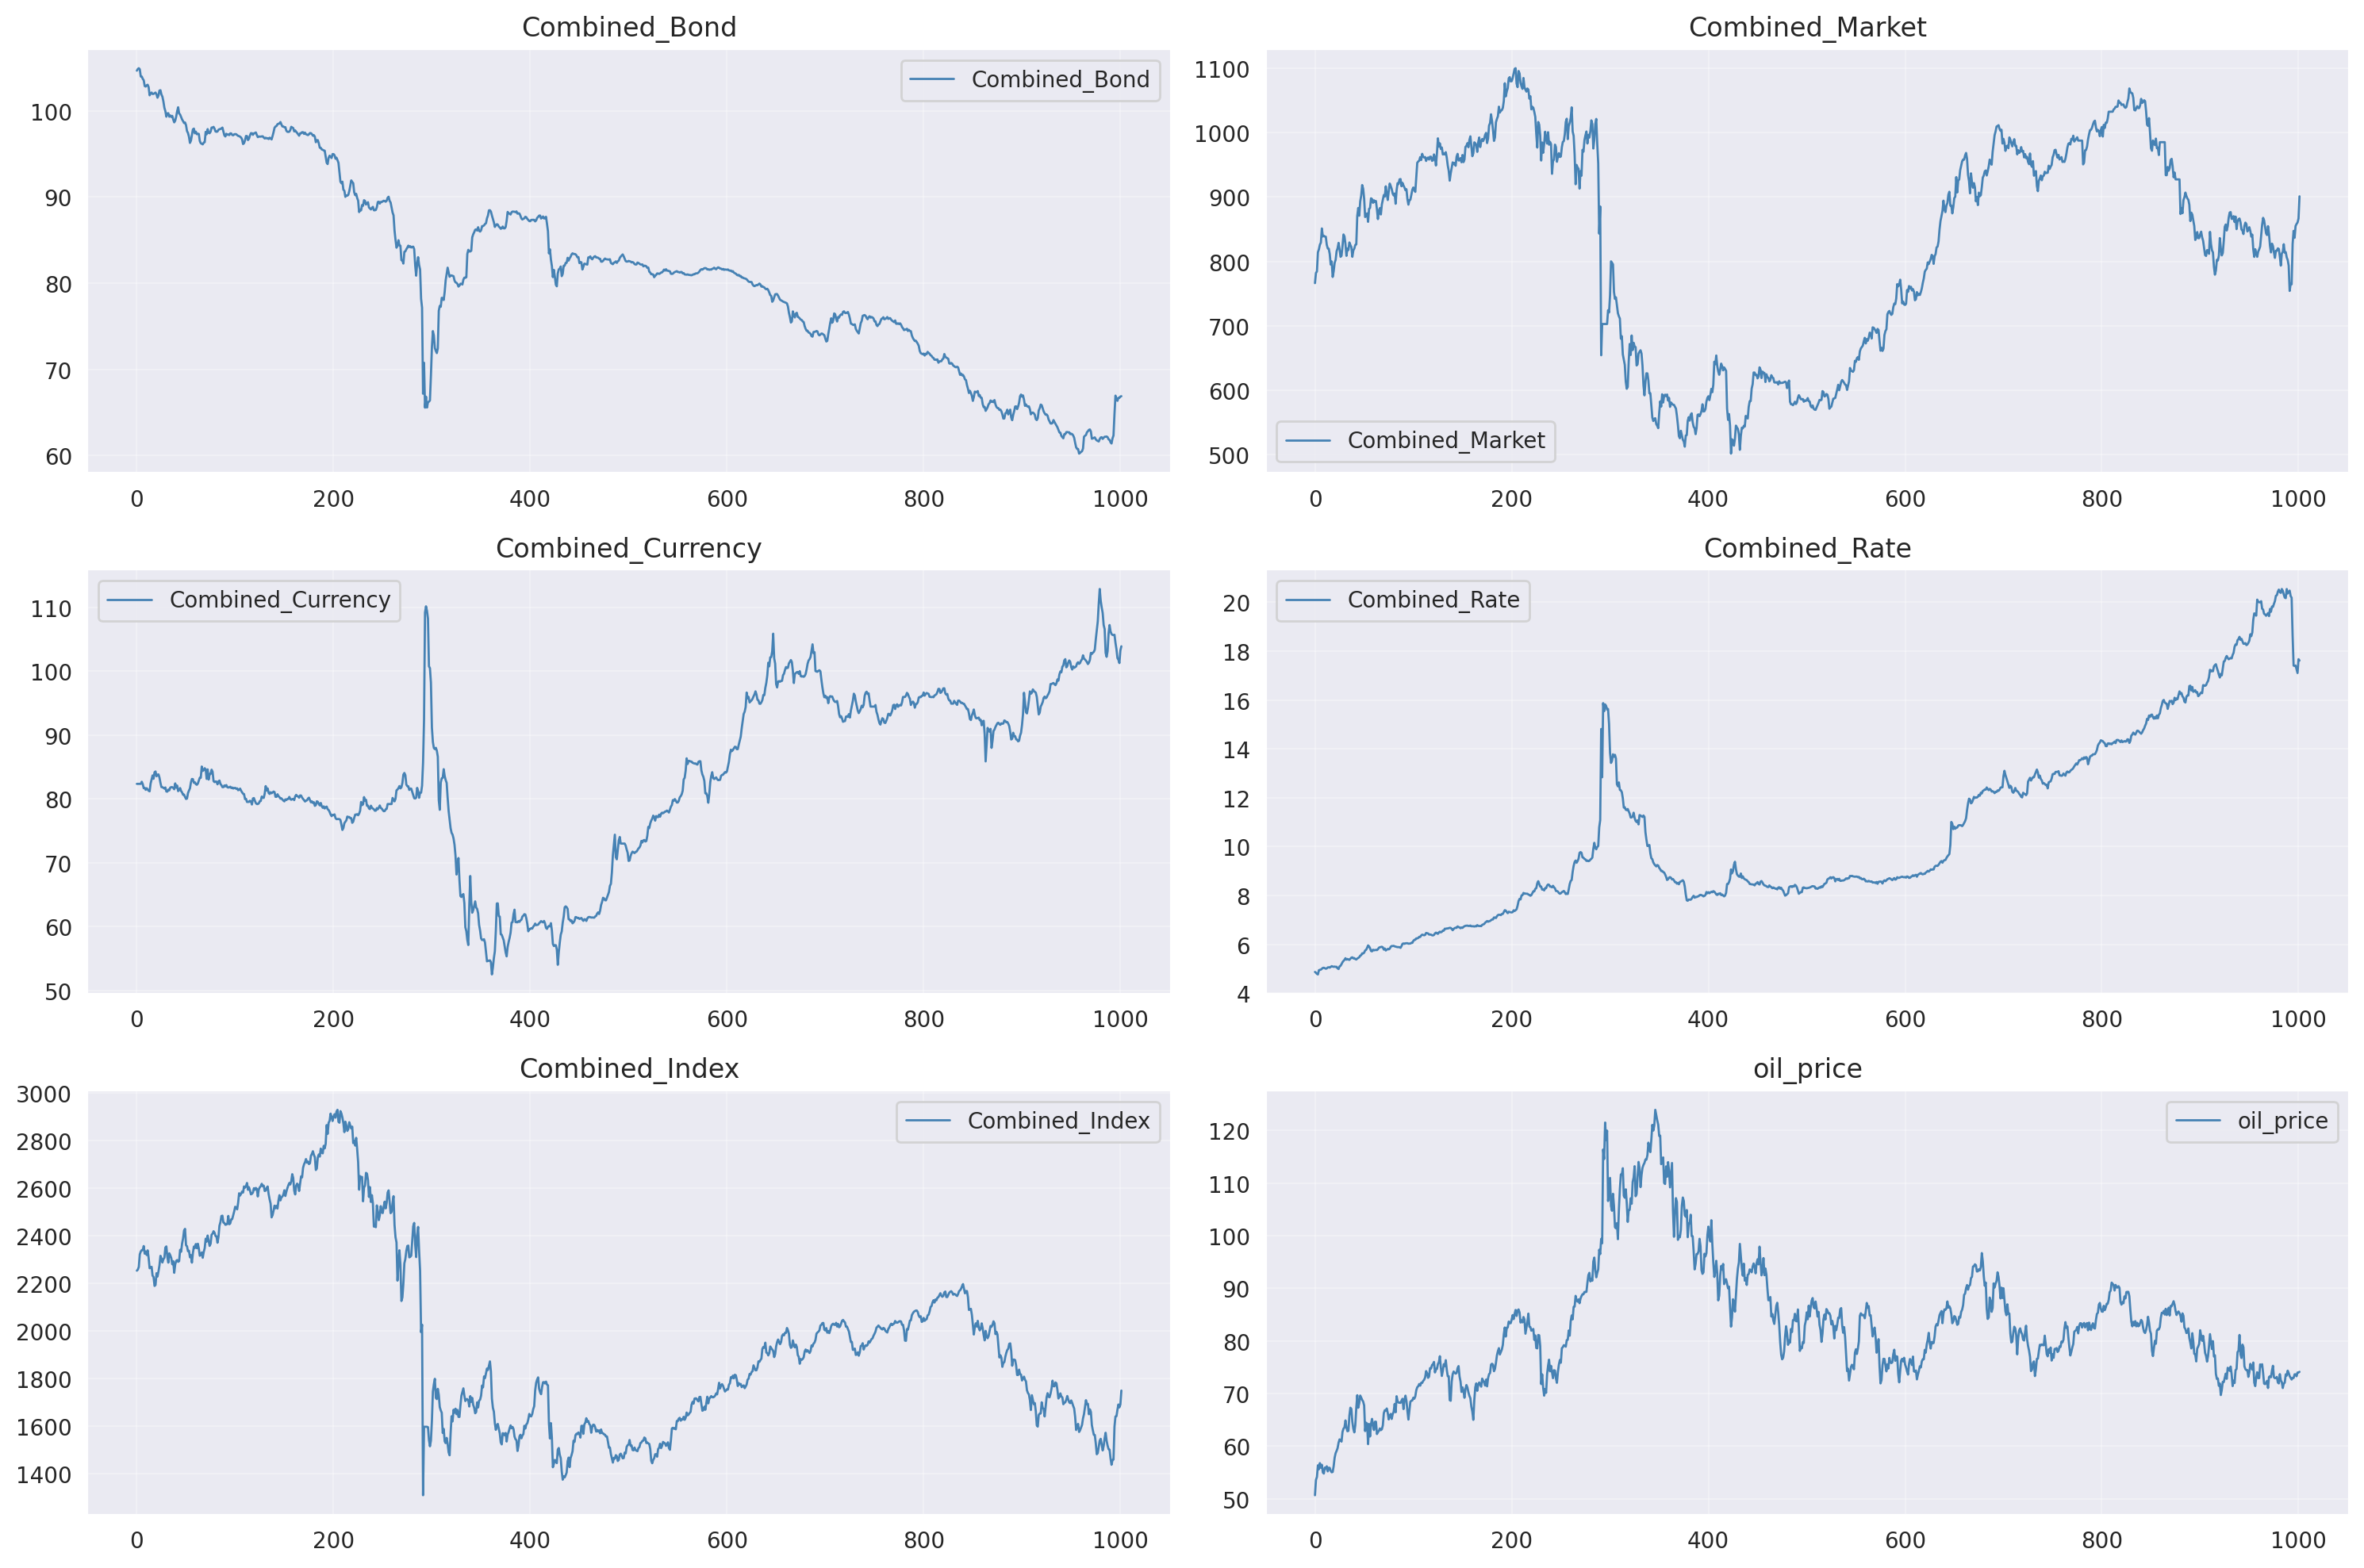

In [17]:
plt.figure(figsize=(15, 10))

# Построение графиков для каждого риск-фактора
for i, col in enumerate(factor_cols, 1):
    plt.subplot(3, 2, i)
    plt.plot(risk_factors_train[col], label=col, color='steelblue', linewidth=1)
    plt.title(col)
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

In [18]:
desc_stats = risk_factors_train.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
desc_stats

Combined_Bond  Combined_Market  Combined_Currency  Combined_Rate  \
count    1002.000000      1002.000000        1002.000000    1002.000000   
mean       81.538821       832.636669          83.727395      10.571689   
std        11.178271       162.292657          13.125889       3.945950   
min        60.217520       501.484311          52.510800       4.769693   
1%         61.525112       528.662623          55.943042       5.014579   
5%         62.709030       562.791606          59.954264       5.664445   
25%        74.400116       675.912362          77.970050       8.068216   
50%        81.444570       870.459941          82.548035       8.787139   
75%        88.755061       968.546190          95.032092      13.098611   
95%        98.568135      1039.993158         101.780737      18.404254   
99%       102.862591      1079.388278         107.226246      20.319706   
max       104.935439      1099.955568         112.866406      20.544444   

       Combined_Index    oil_price  
count     1002.000000  1002.000000  
mean      1984.962125    82.404900  
std        393.775866    12.392334  
min       1308.126263    50.670000  
1%        1440.263081    55.691800  
5%        1492.990561    64.223500  
25%       1655.167754    74.312500  
50%       1927.413626    81.555000  
75%       2306.284484    87.505000  
95%       2706.311271   108.531000  
99%       2882.493635   118.973100  
max       2928.765447   123.940000

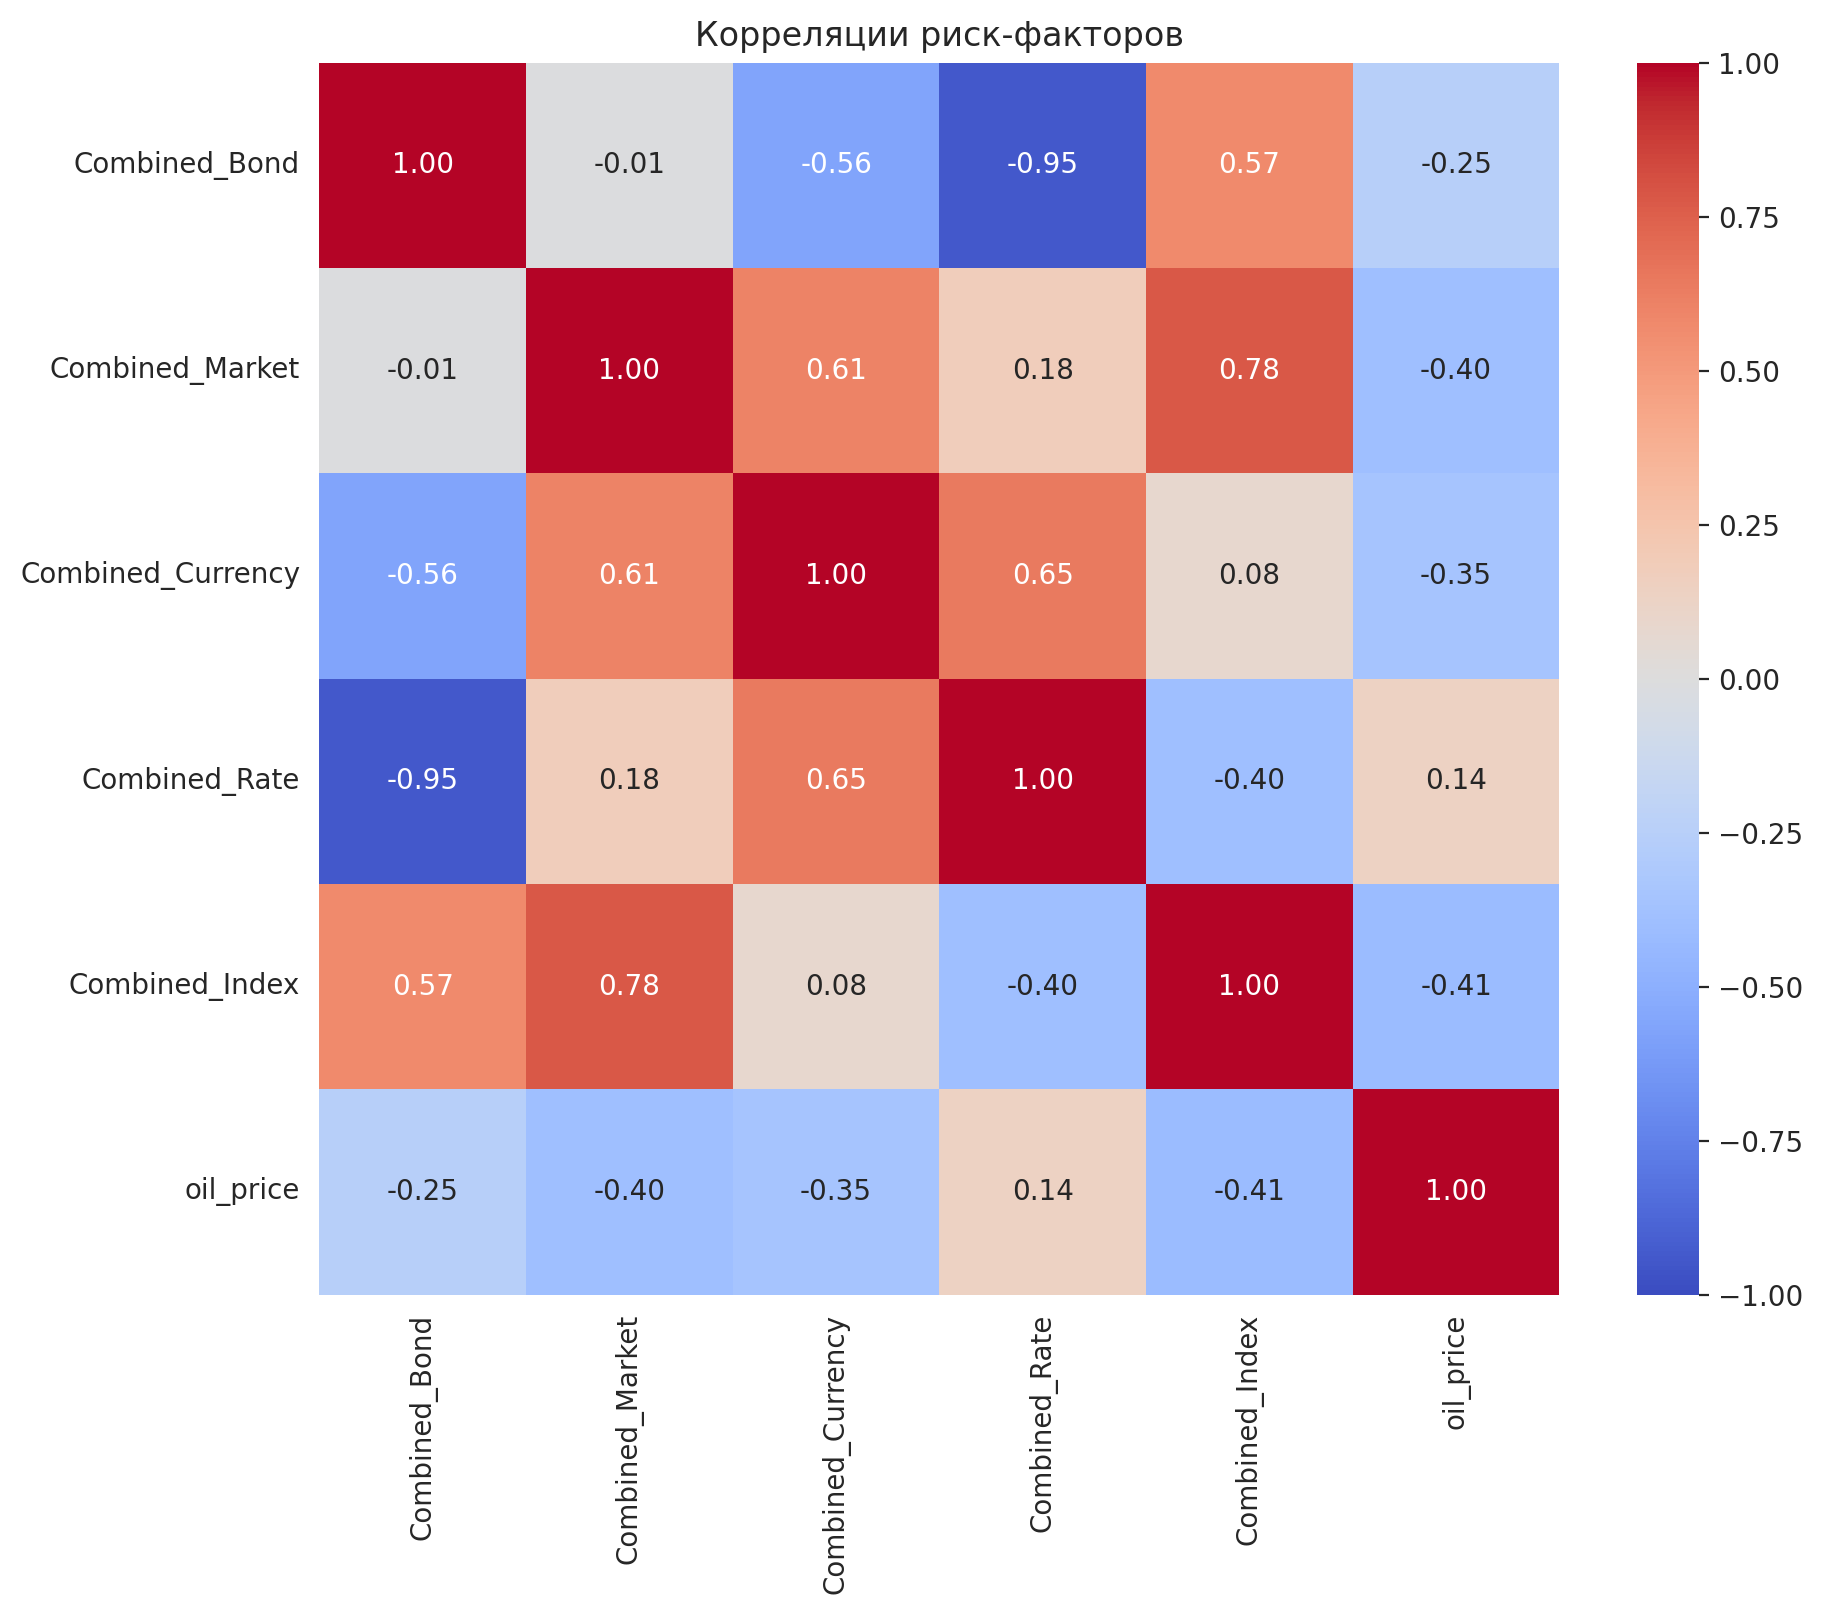

In [19]:
corr_matrix = risk_factors_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Корреляции риск-факторов")
plt.show()

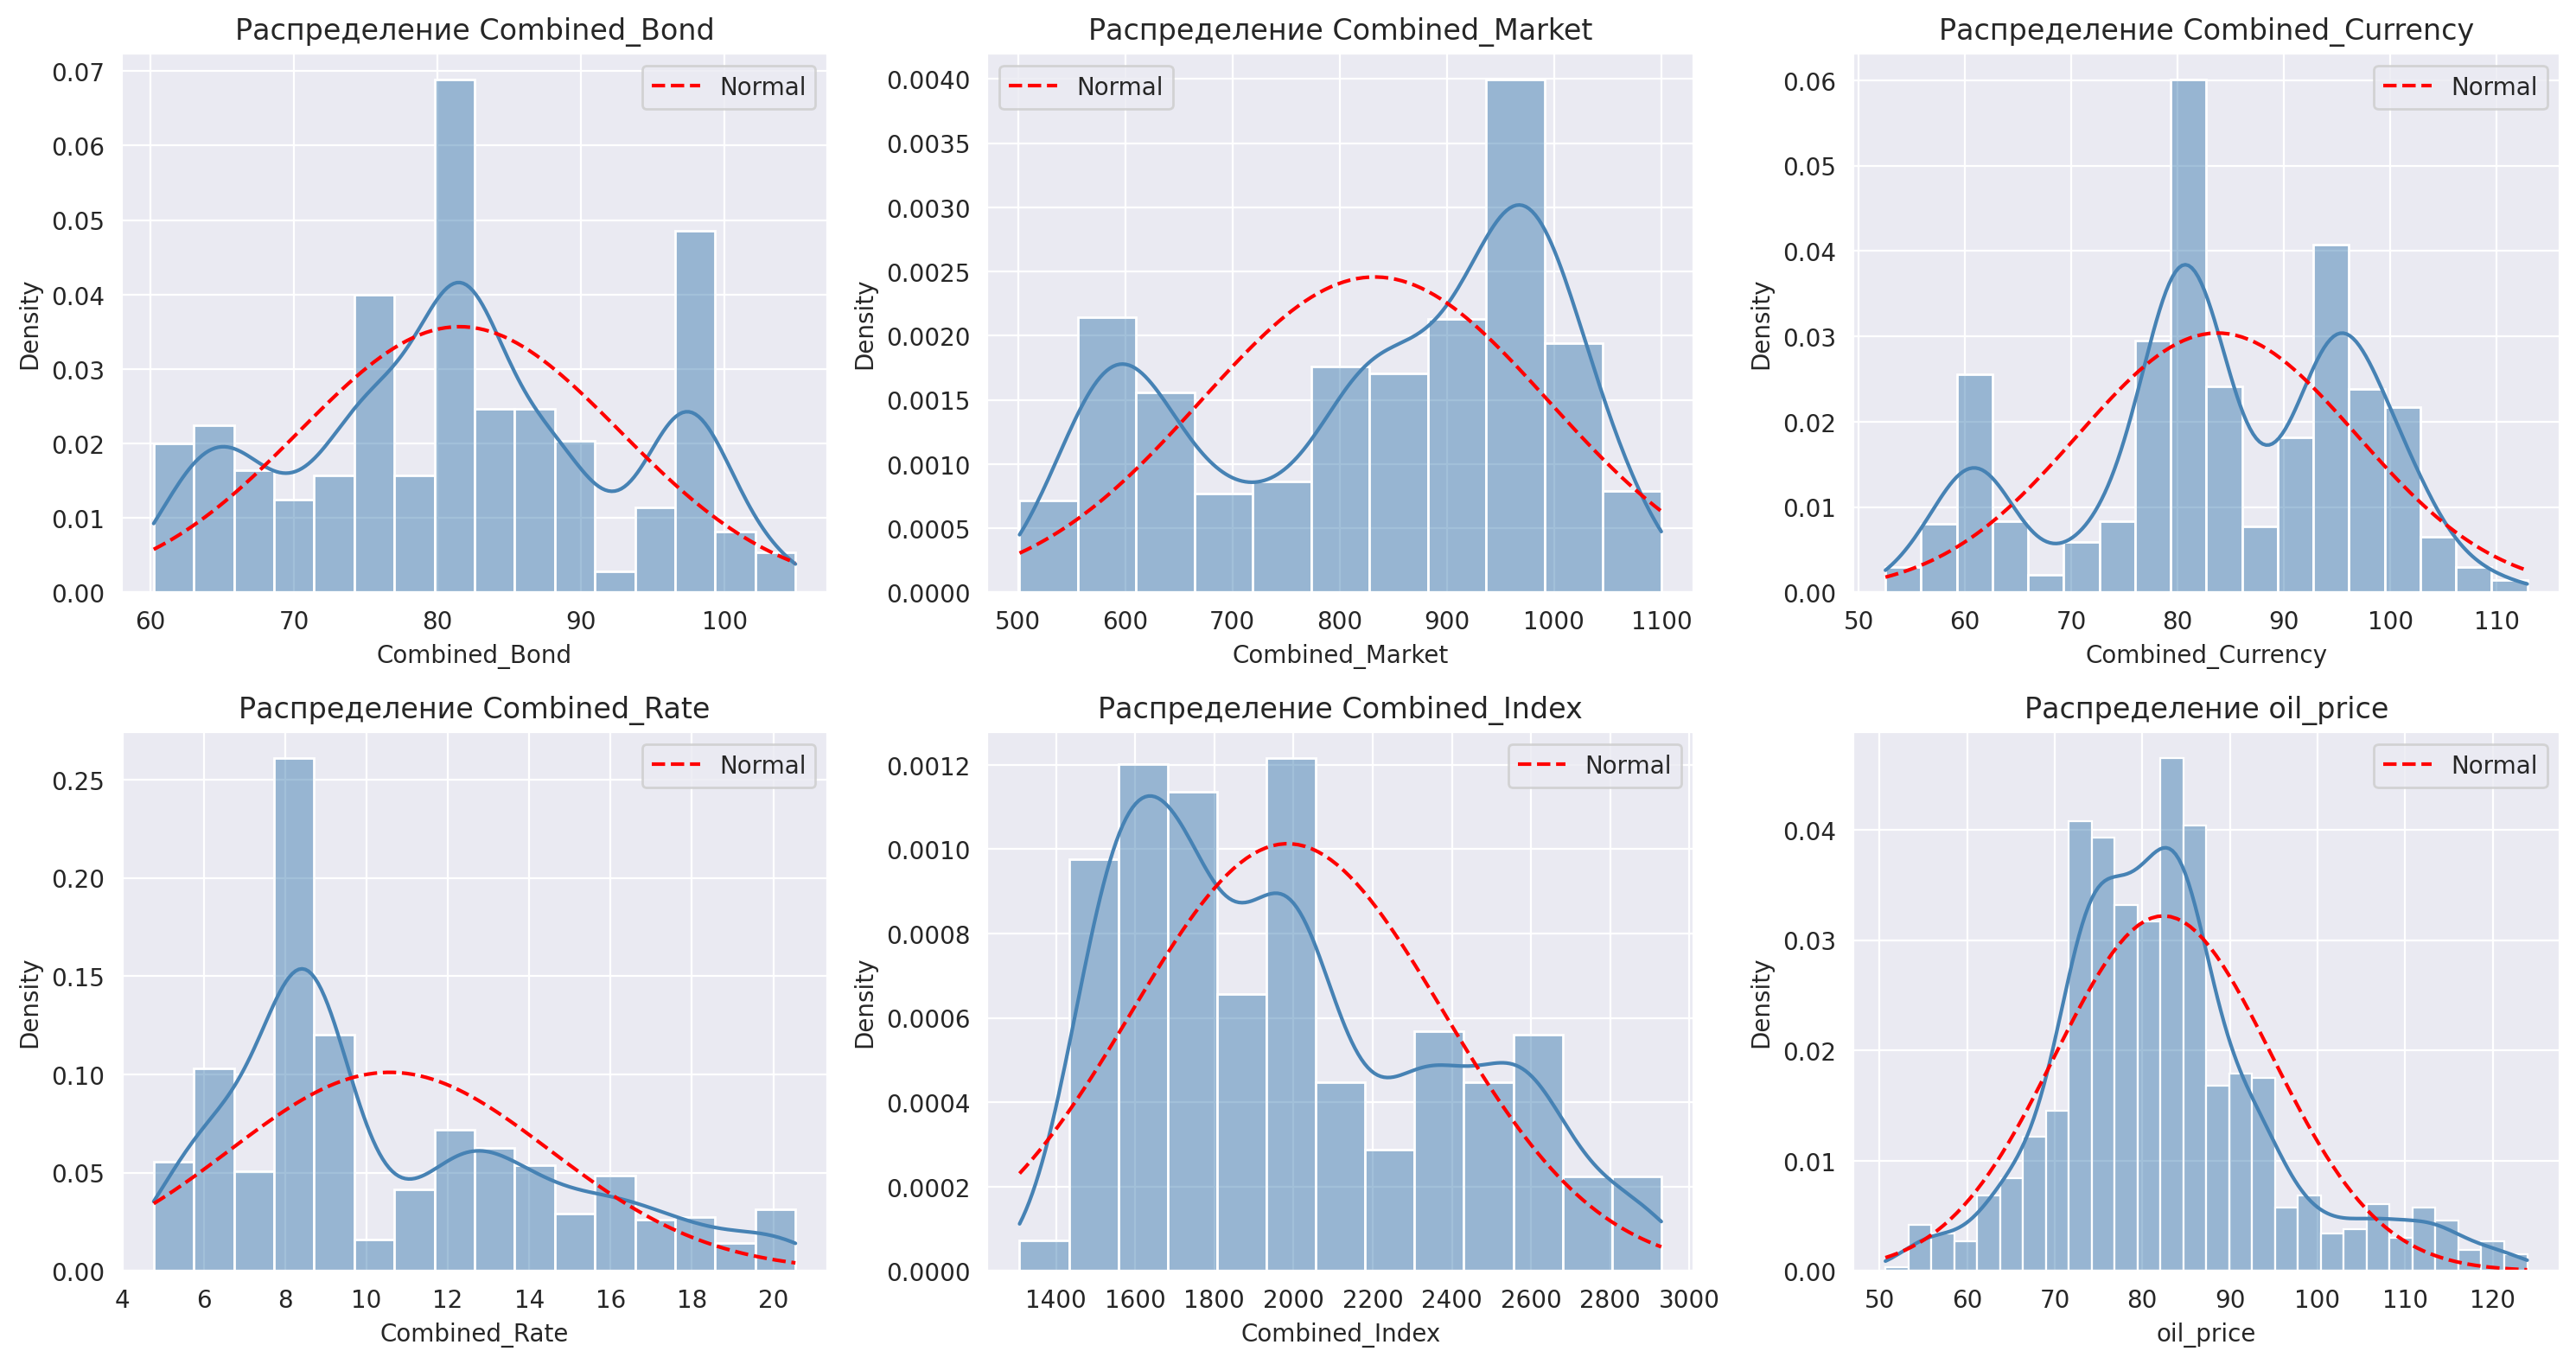

In [20]:
# Определите количество строк, исходя из количества графиков и 3 колонок
n_cols = 3
n_rows = (len(factor_cols) + n_cols - 1) // n_cols  # Округление вверх

# Создаем фигуру с несколькими subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Преобразуем в плоский массив для удобства

for i, col in enumerate(factor_cols):
    ax = axes[i]
    # Гистограмма
    sns.histplot(risk_factors_train[col], kde=True, stat='density', color='steelblue', ax=ax)
    # Нормальное распределение
    x = np.linspace(risk_factors_train[col].min(), risk_factors_train[col].max(), 100)
    normal = norm.pdf(x, loc=risk_factors_train[col].mean(), scale=risk_factors_train[col].std())
    ax.plot(x, normal, 'r--', label='Normal')
    ax.set_title(f"Распределение {col}")
    ax.legend()

# Скрываем лишние subplots, если количество графиков не кратно 3
for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

In [21]:
train_data_risk = risk_factors_train[:len(train_data)]
log_returns = np.log(train_data_risk / train_data_risk.shift(1)).dropna()
log_returns

Combined_Bond  Combined_Market  Combined_Currency  Combined_Rate  \
1         0.001774         0.020480           0.000000      -0.007101   
2         0.000972         0.002957           0.000000      -0.009684   
3        -0.001299         0.037158           0.000000      -0.004432   
4        -0.007875         0.005670           0.000000       0.035716   
5        -0.000093         0.008747           0.003986       0.002887   
..             ...              ...                ...            ...   
974       0.000996        -0.004385           0.003524      -0.000665   
975      -0.003726        -0.011828           0.015568       0.006241   
976      -0.001941        -0.010788           0.012589       0.005583   
977      -0.000998         0.013518           0.013517       0.010843   
978      -0.000979         0.000272           0.025419       0.001261   

     Combined_Index  oil_price  
1          0.001968   0.055655  
2          0.004928   0.010769  
3          0.023098   0.040002  
4          0.005123  -0.013217  
5          0.002499   0.020641  
..              ...        ...  
974       -0.000602   0.012162  
975       -0.023098  -0.029386  
976       -0.030042  -0.002465  
977        0.003306   0.000548  
978        0.018224   0.002874  

[978 rows x 6 columns]

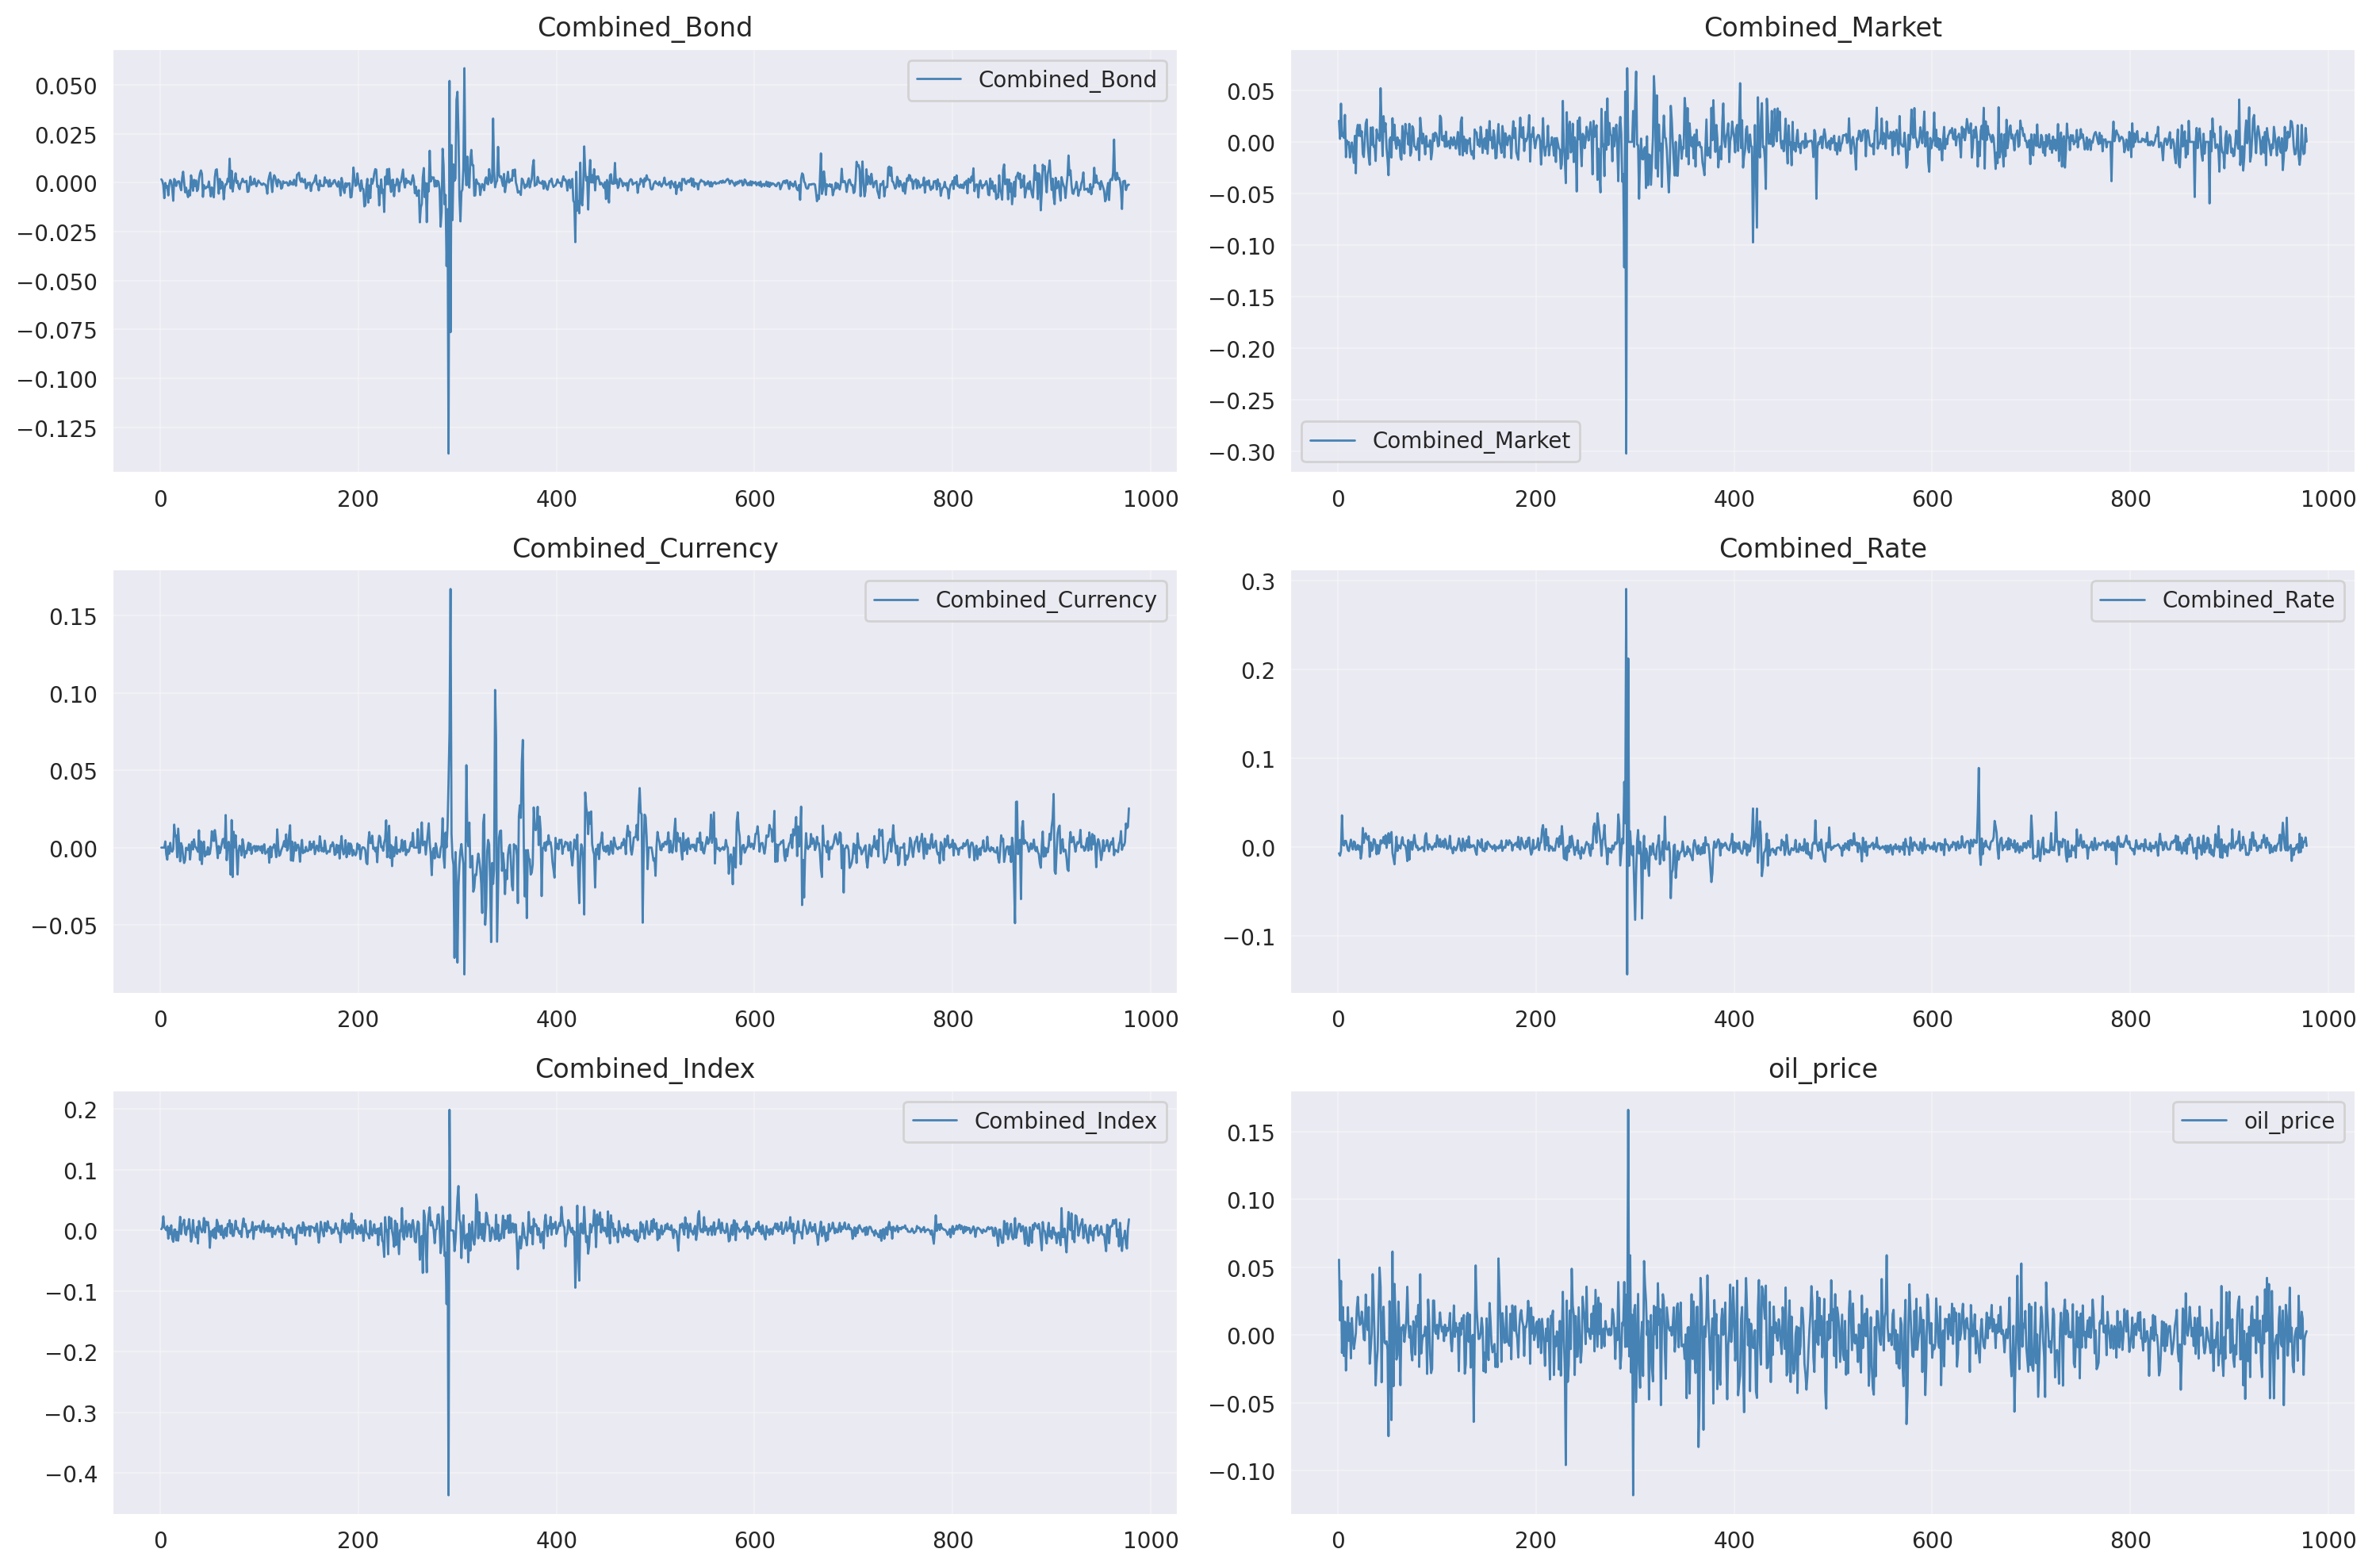

In [22]:
plt.figure(figsize=(15, 10))

# Построение графиков для каждого риск-фактора
for i, col in enumerate(factor_cols, 1):
    plt.subplot(3, 2, i)
    plt.plot(log_returns[col], label=col, color='steelblue', linewidth=1)
    plt.title(col)
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

### Симуляционные модели

**Формирование зависимости между приращениями**

Для этого зададим ковариационную матрицу с помощью разложения Холецкого.

$\Sigma = LL^T$, где L - нижнетреугольная матрица с неотрицптельными коэффициентами, $\Sigma$ - заданная ковариционная матрица.

In [23]:
# Средняя доходность (годовая)
mu = log_returns.mean() * 252  # 252 торговых дня в году

# Волатильность (годовая)
sigma = log_returns.std() * np.sqrt(252)

# Корреляционная матрица
corr_matrix = log_returns.corr()

In [24]:
def vasicek_log_likelihood(params, rates, dt=1/12):
    a, b, sigma = params
    n = len(rates) - 1
    ll = 0
    for i in range(n):
        r_now, r_next = rates[i], rates[i+1]
        mu = b + (r_now - b) * np.exp(-a * dt)
        var = (sigma**2) * (1 - np.exp(-2 * a * dt)) / (2 * a)
        ll += -0.5 * (np.log(2 * np.pi * var) + ((r_next - mu)**2) / var)
    return -ll  # Минимизируем отрицательное правдоподобие

# Исторические данные
bond_rates = risk_factors_train.Combined_Bond.values
short_rates = risk_factors_train.Combined_Rate.values
dt = 1/12  # Шаг времени (месячные данные)

# Оценка параметров для Combined_Bond (индекс 0)
result_bond = minimize(vasicek_log_likelihood, [0.5, np.mean(bond_rates), np.std(bond_rates)],
                       args=(bond_rates, dt), bounds=[(0.001, 10), (0, None), (0.001, None)])
a_bond, b_bond, sigma_bond = result_bond.x

# Оценка параметров для Combined_Rate (индекс 3)
result_rate = minimize(vasicek_log_likelihood, [0.5, np.mean(short_rates), np.std(short_rates)],
                       args=(short_rates, dt), bounds=[(0.001, 10), (0, None), (0.001, None)])
a_rate, b_rate, sigma_rate = result_rate.x

In [27]:
def multi_asset_hybrid_simulations(S0_list, mu_list, sigma_list, corr_matrix, T, N, n_simulations=1000,
                                  vasicek_params=None, vasicek_indices=None, seed=None):
    """
    Генерирует траектории для:
    - Активов, моделируемых GBM (акции, валюта, товары).
    - Активов, моделируемых Vasicek (облигации и процентные ставки).

    Параметры:
    - S0_list: список начальных значений.
    - mu_list: дрейфы для GBM (игнорируется для Vasicek).
    - sigma_list: волатильности для GBM / параметр sigma для Vasicek.
    - corr_matrix: общая корреляционная матрица (включая Vasicek).
    - T: период моделирования (в годах).
    - N: число шагов.
    - vasicek_params: словарь с параметрами Vasicek для выбранных активов:
        {'a': скорость возврата, 'b': долгосрочное среднее, 'sigma': волатильность}.
    - vasicek_indices: индексы активов в S0_list, которые моделируются Vasicek (например, [0, 3]).
    - seed: для воспроизводимости.

    Возвращает:
    - t: массив времени (N+1 точек).
    - S: массив цен (размер: (n_simulations, n_assets, N+1)).
    """
    if seed is not None:
        np.random.seed(seed)

    n_assets = len(S0_list)
    dt = T / N
    t = np.linspace(0, T, N+1)

    # Разложение Холецкого
    L = np.linalg.cholesky(corr_matrix)

    # Массив для хранения всех симуляций
    S = np.zeros((n_simulations, n_assets, N+1))
    S[:, :, 0] = S0_list

    for i in range(n_simulations):
        # Генерация независимых шоков (размер: (N, n_assets))
        Z = np.random.standard_normal(size=(N, n_assets))
        dW = (Z @ L.T) * np.sqrt(dt)  # Коррелированные шоки

        for j in range(1, N+1):
            for k in range(n_assets):
                if vasicek_indices and k in vasicek_indices:
                    # Моделирование Vasicek для выбранных активов (например, Combined_Bond и Combined_Rate)
                    idx = vasicek_indices.index(k)
                    params = vasicek_params[idx]
                    a, b, sigma = params['a'], params['b'], params['sigma']
                    r_prev = S[i, k, j-1]
                    dr = a * (b - r_prev) * dt + sigma * dW[j-1, k]
                    S[i, k, j] = r_prev + dr
                else:
                    # Моделирование GBM для остальных активов
                    drift = (mu_list[k] - 0.5 * sigma_list[k]**2) * dt
                    diffusion = sigma_list[k] * dW[j-1, k]
                    S[i, k, j] = S[i, k, j-1] * np.exp(drift + diffusion)

    return S

In [28]:
S0_list = data[data['begin'] == '2024-12-02'][factor_cols].values[0]      # Начальная цена
T = 10 / 252   # 10 дней
N = 10         # 10 шагов
n_simulations = 10_000  # Количество траекторий

# Параметры Vasicek для Combined_Bond (индекс 0) и Combined_Rate (индекс 3)
vasicek_params = [
    {'a': a_bond, 'b': b_bond, 'sigma': sigma_bond},  # Для Combined_Bond (индекс 0)
    {'a': a_rate, 'b': b_rate, 'sigma': sigma_rate}   # Для Combined_Rate (индекс 3)
]
vasicek_indices = [0, 3]

# Запуск симуляции
S = multi_asset_hybrid_simulations(
    S0_list=S0_list,
    mu_list=mu.values,
    sigma_list=sigma.values,
    corr_matrix=corr_matrix.values,
    T=T,
    N=N,
    n_simulations=n_simulations,
    vasicek_params=vasicek_params,
    vasicek_indices=vasicek_indices,
    seed=42
)

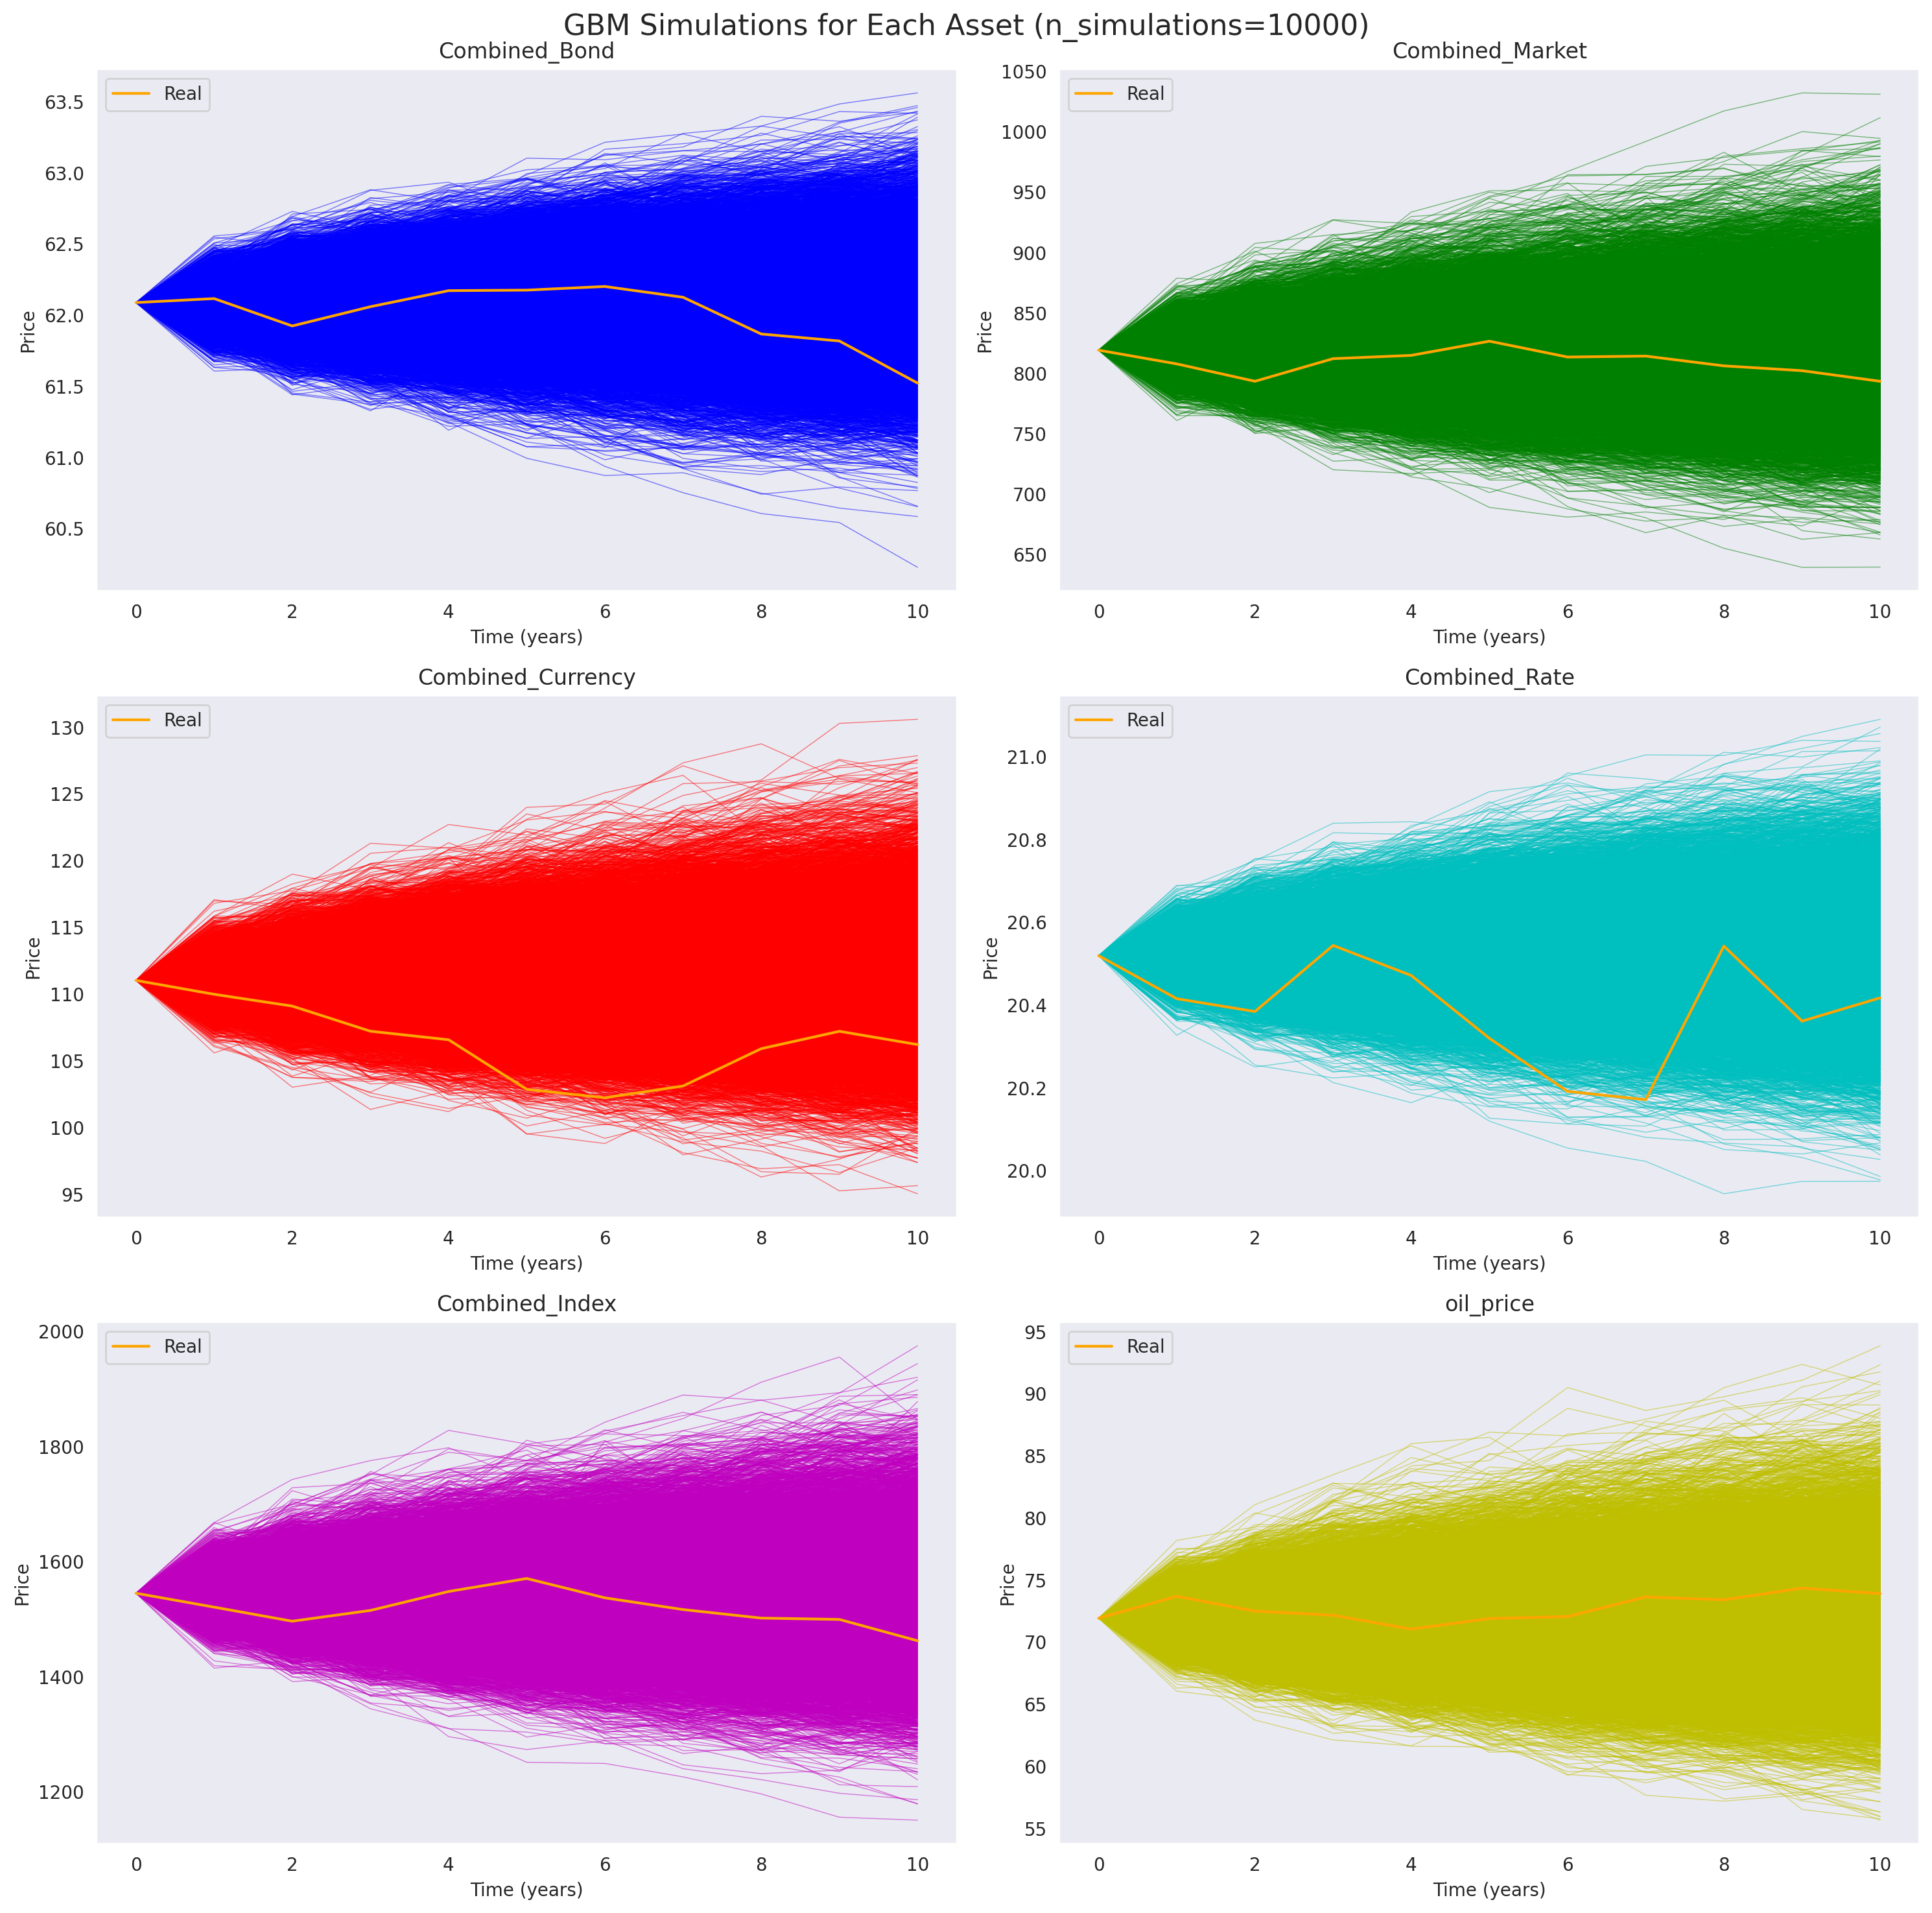

In [29]:
# Настройка сетки графиков (3 строки, 2 колонки)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.suptitle('GBM Simulations for Each Asset (n_simulations={})'.format(n_simulations), fontsize=16)

# Цвета для каждого актива
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Названия активов (замените на ваши)
asset_names = ['Combined_Bond', 'Combined_Market', 'Combined_Currency',
               'Combined_Rate', 'Combined_Index', 'oil_price']

# Отрисовка каждого актива в своём subplot
for asset_idx in range(S.shape[1]):  # Для каждого актива
    row = asset_idx // 2  # Номер строки (0, 1, 2)
    col = asset_idx % 2   # Номер колонки (0, 1)
    ax = axes[row, col]

    # Траектории (тонкие линии)
    for sim_idx in range(n_simulations):
        ax.plot(S[sim_idx, asset_idx, :], color=colors[asset_idx], alpha=0.5, linewidth=0.5)

    ax.plot(data[data['begin'] >= '2024-12-02'][asset_names[asset_idx]][:11].values, color='orange', label='Real')
    # Настройки графика
    ax.set_title(asset_names[asset_idx])
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Price')
    ax.grid()
    ax.legend()

# Убираем пустые subplot (если активов меньше 6)
if S.shape[1] < 6:
    for i in range(S.shape[1], 6):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### Справедливая стоимость

In [30]:
X_train = train_data_risk.copy()
y_train = data[data['begin'] <= test_date].iloc[1:,1:]

X_test = risk_factors_train[len(train_data)+1:]
y_test = data[data['begin'] > test_date].iloc[:,1:]

models = {}

In [31]:
X_train

Combined_Bond  Combined_Market  Combined_Currency  Combined_Rate  \
0       104.647668       766.174692          82.351995       4.871971   
1       104.833527       782.027521          82.351995       4.837498   
2       104.935439       784.343359          82.351995       4.790880   
3       104.799196       814.036154          82.351995       4.769693   
4       103.977176       818.664803          82.351995       4.943125   
..             ...              ...                ...            ...   
974      62.099432       823.834759         103.383597      19.811629   
975      61.868458       814.147505         105.005679      19.935652   
976      61.748470       805.411630         106.335918      20.047269   
977      61.686864       816.373204         107.782986      20.265830   
978      61.626522       816.595361         110.557823      20.291406   

     Combined_Index  oil_price  
0       2252.403660      50.67  
1       2256.840944      53.57  
2       2267.991029      54.15  
3       2320.987725      56.36  
4       2332.908925      55.62  
..              ...        ...  
974     1561.232785      75.28  
975     1525.585142      73.10  
976     1480.435497      72.92  
977     1485.338121      72.96  
978     1512.654728      73.17  

[979 rows x 6 columns]

In [32]:
use_column = X_train.columns
for share in market_set:
    model = LinearRegression()
    model.fit(X_train[use_column], y_train[share])
    models[share] = model
    prediction = model.predict(X_test[use_column])
    mae = mean_absolute_error(y_test[share], prediction)
    mape = mean_absolute_percentage_error(y_test[share], prediction)

    print(f"{share} test| MAE: {round(mae, 4)} | MAPE: {round(mape, 4)}\n"+"-"*50)

LKOH test| MAE: 79.0569 | MAPE: 0.0116
--------------------------------------------------
AFLT test| MAE: 5.2237 | MAPE: 0.1025
--------------------------------------------------
GMKN test| MAE: 19.2835 | MAPE: 0.1846
--------------------------------------------------
NVTK test| MAE: 62.9357 | MAPE: 0.0748
--------------------------------------------------
SBER test| MAE: 9.1604 | MAPE: 0.0368
--------------------------------------------------
AFKS test| MAE: 4.5206 | MAPE: 0.3567
--------------------------------------------------
CHMF test| MAE: 151.4181 | MAPE: 0.1361
--------------------------------------------------
ROSN test| MAE: 40.9389 | MAPE: 0.0741
--------------------------------------------------
VTBR test| MAE: 10.0188 | MAPE: 0.1492
--------------------------------------------------
RASP test| MAE: 18.9294 | MAPE: 0.0766
--------------------------------------------------


In [41]:
use_column = X_train.columns
for bond in debt_set:
    model = LinearRegression()
    model.fit(X_train[use_column], y_train[bond])
    prediction = model.predict(X_test[use_column])
    models[bond] = model
    mae = mean_absolute_error(y_test[bond], prediction)
    mape = mean_absolute_percentage_error(y_test[bond], prediction)

    print(f"{bond} test| MAE: {round(mae, 4)} | MAPE: {round(mape, 4)}\n"+"-"*50)

SU26207RMFS9 test| MAE: 0.643 | MAPE: 0.008
--------------------------------------------------
SU26225RMFS1 test| MAE: 1.4333 | MAPE: 0.0245
--------------------------------------------------
SU26229RMFS3 test| MAE: 0.7208 | MAPE: 0.0079
--------------------------------------------------
SU26233RMFS5 test| MAE: 1.2155 | MAPE: 0.0226
--------------------------------------------------
SU26235RMFS0 test| MAE: 0.6012 | MAPE: 0.0102
--------------------------------------------------


In [42]:
for curr in currency_set:
    model = LinearRegression()
    model.fit(X_train, y_train[curr])
    models[curr] = model
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test[curr], prediction)
    mape = mean_absolute_percentage_error(y_test[curr], prediction)

    print(f"{curr} test| MAE: {round(mae, 4)} | MAPE: {round(mape, 4)}\n"+"-"*50)

euro_cb test| MAE: 2.2766 | MAPE: 0.0211
--------------------------------------------------
usd_cb test| MAE: 2.2837 | MAPE: 0.0222
--------------------------------------------------


In [35]:
shares = {
    'LKOH':1,
    'AFLT':1,
    'GMKN':1,
    'NVTK':1,
    'SBER':1,
    'AFKS':1,
    'CHMF':1,
    'ROSN':1,
    'VTBR':1,
    'RASP':1,
    'euro_cb':100,
    'usd_cb':100,
    'SU26207RMFS9':10,
    'SU26225RMFS1':10,
    'SU26229RMFS3':10,
    'SU26233RMFS5':10,
    'SU26235RMFS0':10
}
total = sum(shares.values())
shares = {k : (v / total) for k, v in shares.items()}
shares_df = pd.DataFrame(shares, index=[0])

In [36]:
def predict_value(data:pd.DataFrame, models:dict) -> pd.DataFrame:
    """
    Педсказания значения цен на определенный день

    Args:
        data (pd.DataFrame): данные на интересуюший нас день
        models (dict): сдлварь с можелями предсказаний для конкретных активов

    Returns:
        values_df (pd.DataFrame): таблица с предсказанными ценами
    """
    values = {}
    for name, model in models.items():
        prediction = model.predict(data)
        values[name] = prediction
    values_df = pd.DataFrame(values)
    return values_df

In [37]:
def draw_count_var_es(loss_profit_list):
  var = np.quantile(loss_profit_list, q=0.01)

  loss_profit_array = np.array(loss_profit_list)
  sorted_losses = np.sort(loss_profit_array)

  # Расчет VaR 99% (1-й процентиль)
  var_99 = np.percentile(sorted_losses, 100-99)

  assert var_99 == var

  # Расчет ES 97.5% (среднее значений выше 97.5 перцентиля)
  percentile_97_5 = np.percentile(sorted_losses, 100-97.5)
  es_97_5 = sorted_losses[sorted_losses <= percentile_97_5].mean()

  print(f"Value-at-Risk (99%): {var_99:.2f}")
  print(f"Expected Shortfall (97.5%): {es_97_5:.2f}")

  # Построение графика распределения убытков с VaR и ES
  plt.figure(figsize=(12, 6))
  sns.histplot(loss_profit_array, kde=True, bins=50, color='blue', alpha=0.5)

  # Добавление линий для VaR и ES
  plt.axvline(x=var_99, color='red', linestyle='--', label=f'VaR 99%: {var_99:.2f}')
  plt.axvline(x=es_97_5, color='green', linestyle='--', label=f'ES 97.5%: {es_97_5:.2f}')

  # Закрашивание области для ES
  plt.axvspan(loss_profit_array.min(), percentile_97_5, alpha=0.1, color='green')

  plt.title('Распределение убытков с VaR и ES')
  plt.xlabel('Убытки')
  plt.ylabel('Частота')
  plt.legend()
  plt.grid(True)
  plt.show()

In [38]:
base_prices = data[data['begin'] == '2024-12-02'][shares.keys()]

Value-at-Risk (99%): -2.13
Expected Shortfall (97.5%): -2.15


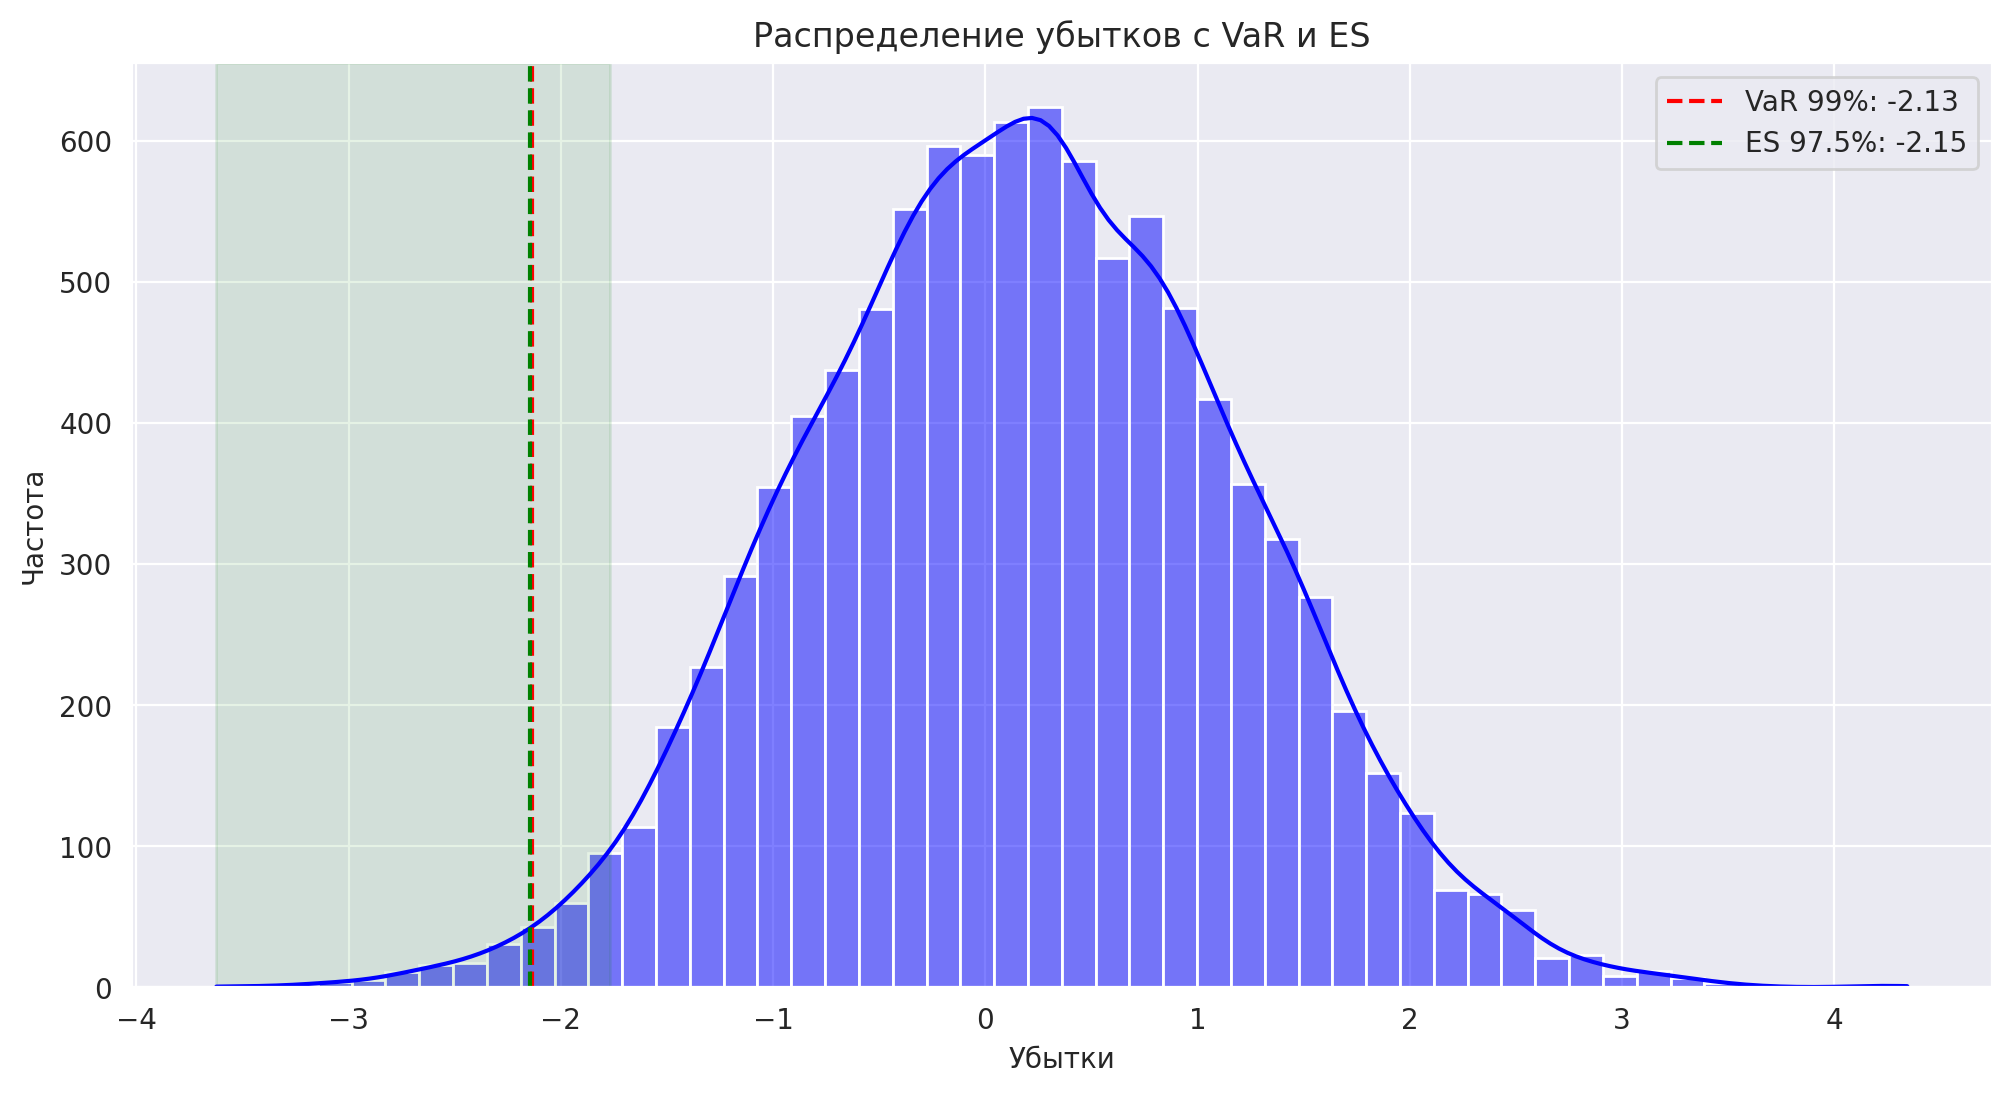

In [39]:
first_day_values = S[:, :, 1]  # Размерность: (n_simulations, n_assets)
df_first_day = pd.DataFrame(first_day_values, columns=asset_names)
predicted_prices = predict_value(df_first_day, models)
# loss_profit_list = ((predicted_prices - base_prices.iloc[-1]) * shares_df.iloc[-1]).sum(axis=1).to_list()
loss_profit_list = ((predicted_prices - base_prices.iloc[-1]) / base_prices.iloc[-1]  * shares_df.iloc[-1]).sum(axis=1).to_list()
loss_profit_np = np.array(loss_profit_list) * 100
draw_count_var_es(loss_profit_np)

Value-at-Risk (99%): -6.65
Expected Shortfall (97.5%): -6.71


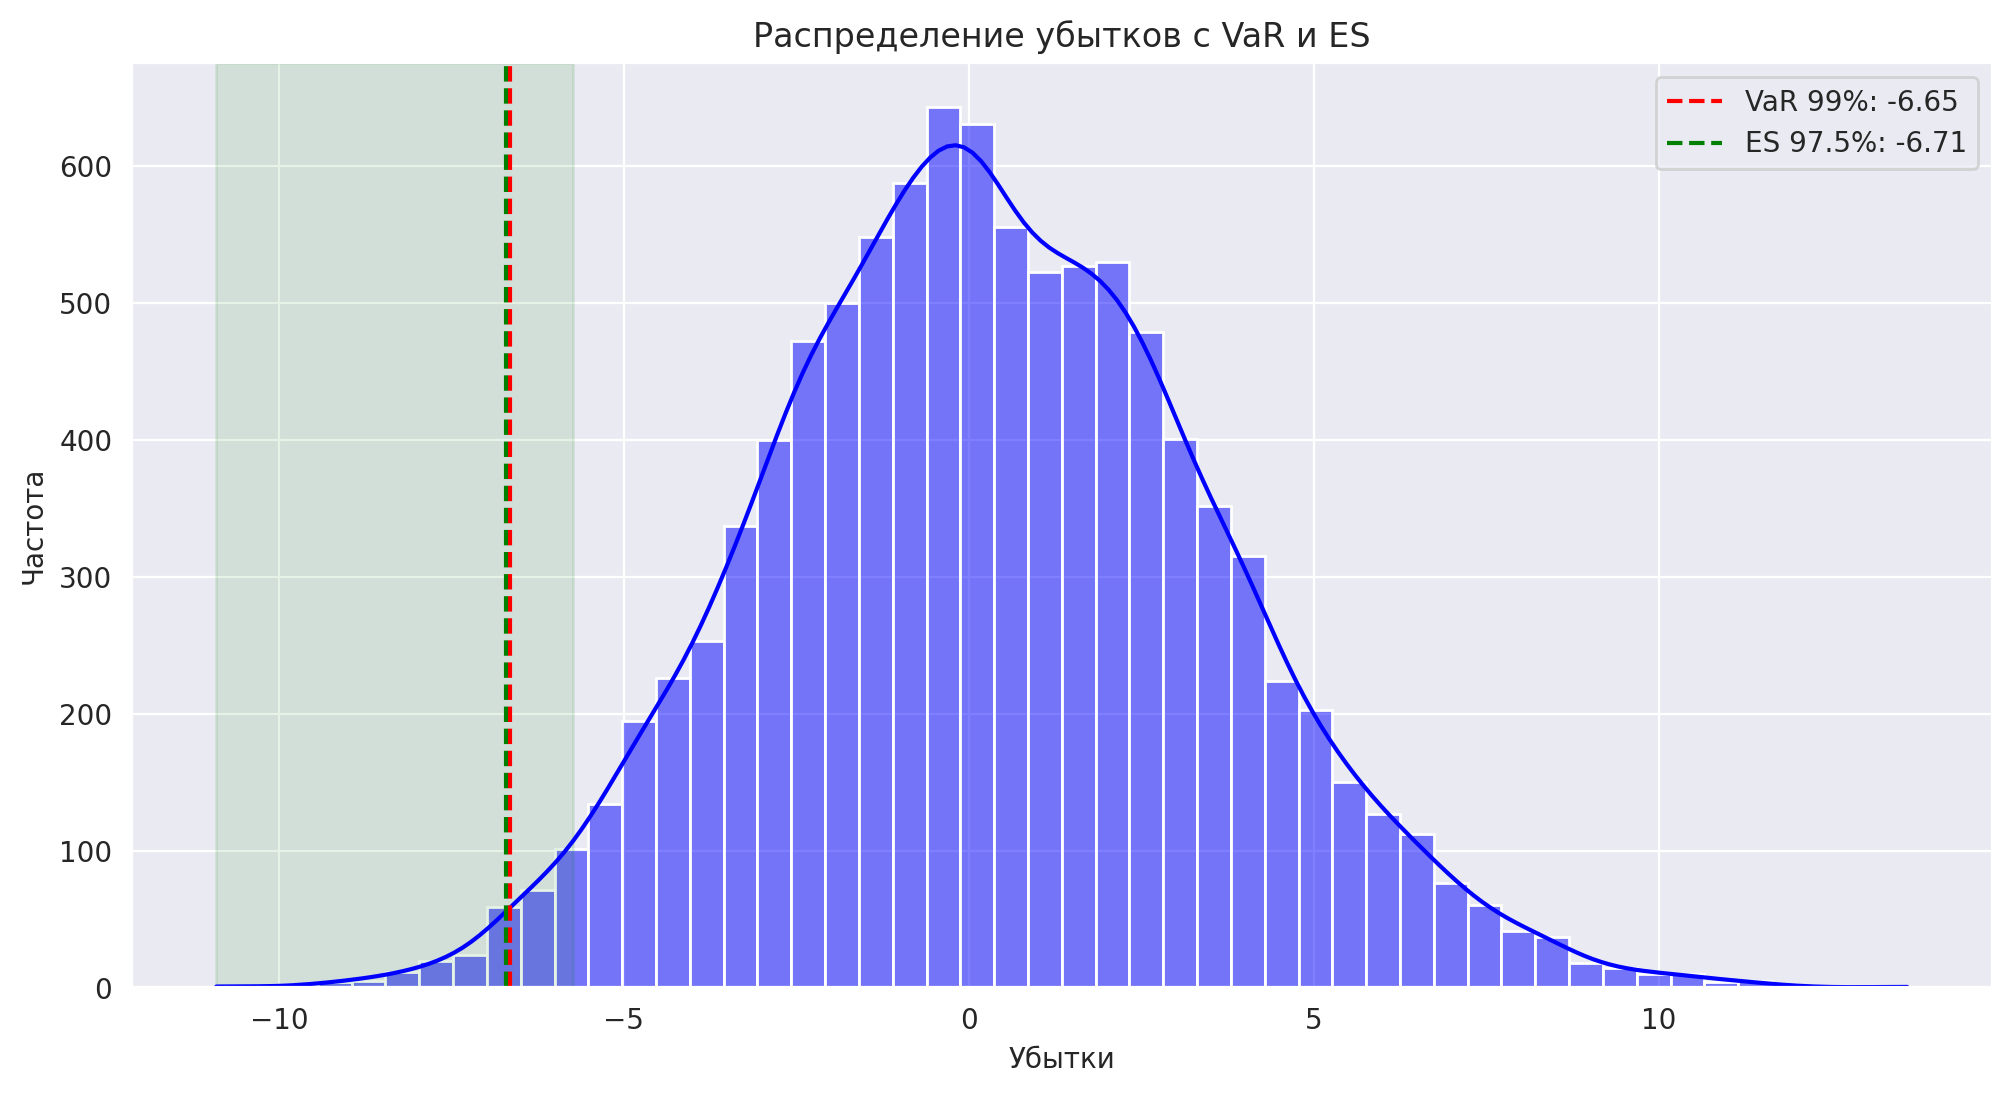

In [40]:
last_day_values = S[:, :, -1]  # Размерность: (n_simulations, n_assets)
df_last_day = pd.DataFrame(last_day_values, columns=asset_names)
predicted_prices = predict_value(df_last_day, models)
# loss_profit_list = ((predicted_prices - base_prices.iloc[-1]) * shares_df.iloc[-1]).sum(axis=1).to_list()
loss_profit_list = ((predicted_prices - base_prices.iloc[-1]) / base_prices.iloc[-1]  * shares_df.iloc[-1]).sum(axis=1).to_list()
loss_profit_np = np.array(loss_profit_list) * 100
draw_count_var_es(loss_profit_np)